In [33]:
# ============================================================
# 015 PDF to Notion and Slides with Gemini
# ============================================================
#
# Overview
# --------
# This notebook implements an end-to-end research workflow that transforms
# academic PDFs into structured knowledge artifacts and visual summaries.
#
# The pipeline is designed to:
#   - Parse and understand academic papers using LLM-based structured extraction
#   - Store normalized research summaries in Notion as a persistent knowledge base
#   - Generate slide-ready visual one-pagers using Gemini (Nano Banana)
#
# Rather than simply "reading" PDFs, the goal is to treat papers as structured
# inputs that can be reused across research synthesis, policy analysis,
# and presentation workflows.
#
#
# Structure
# ---------
# The notebook is organized as a modular, inspectable pipeline:
#
#   0. Notebook Overview / Purpose
#   1. Environment & API Setup
#   2. Configuration / Run Parameters
#   3. PDF Ingestion
#   4. Text & Structure Extraction
#   5. Paper Understanding (LLM Parsing)
#   6. Notion Formatting
#   7. Slide Spec Generation (Intermediate Representation)
#   8. Slide Image Generation (Gemini / Nano Banana)
#   9. Save Data (Google Drive + Notion)
#
# Each step is designed to be independently re-runnable and debuggable,
# enabling partial execution, inspection of intermediate artifacts,
# and future extensions (e.g., batch processing or re-generation).
#
#
# Notes
# -----
# - This notebook prioritizes explicit intermediate representations
#   (JSON, structured specs) over ad-hoc prompt outputs.
# - Notion is treated as the single source of truth for validated paper summaries.
# - Visual slide generation is intentionally placed at the final stage, ensuring
#   that images are derived only from structured, reviewable inputs.
# - The overall design emphasizes reproducibility, clarity, and extensibility,
#   rather than one-off prompt experimentation.


In [34]:
# ============================================================
# 1. Environment & API Setup
# ============================================================
#
# This section initializes and validates all external services
# used throughout the notebook:
#   - OpenAI (LLM-based paper understanding & structuring)
#   - Notion (persistent knowledge base)
#   - Google Drive (PDF ingestion source)
#   - Gemini / Nano Banana (slide image generation)
#
# All credentials are loaded from an explicit env.txt file.
# This cell is intended to fail fast if any required setup
# is missing or misconfigured.
#

import os
import requests
from dotenv import load_dotenv

# ------------------------------------------------------------
# Load environment variables
# ------------------------------------------------------------
# Explicitly load env.txt (instead of default .env)
load_dotenv("env.txt")


# ============================================================
# OpenAI configuration
# ============================================================

# Validate OpenAI API key
# (Do NOT print the actual key for security reasons)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if OPENAI_API_KEY is None:
    raise ValueError(
        "OPENAI_API_KEY could not be loaded from env.txt. "
        "Please verify the file contents."
    )
else:
    print("✅ OPENAI_API_KEY loaded successfully")

# Initialize OpenAI client
from openai import OpenAI
openai_client = OpenAI(api_key=OPENAI_API_KEY)


# ============================================================
# Notion configuration and authentication check
# ============================================================

NOTION_TOKEN = os.getenv("NOTION_TOKEN")
NOTION_LIT_DB_ID = os.getenv("NOTION_LIT_DB_ID")
NOTION_VERSION = os.getenv("NOTION_VERSION")               

if NOTION_TOKEN is None:
    raise ValueError("NOTION_TOKEN could not be loaded from env.txt")

NOTION_HEADERS = {
    "Authorization": f"Bearer {NOTION_TOKEN}",
    "Notion-Version": NOTION_VERSION,
    "Content-Type": "application/json",
}

# Simple authentication check against Notion API
r = requests.get(
    "https://api.notion.com/v1/users/me",
    headers=NOTION_HEADERS,
    timeout=30
)

if r.status_code != 200:
    print("❌ Notion authentication failed")
    print(r.json())
else:
    print("✅ Notion authentication OK")


# ============================================================
# Google Drive configuration (PDF ingestion)
# ============================================================

# OAuth credential paths (Desktop App flow)
GOOGLE_OAUTH_CLIENT_SECRET_JSON = os.getenv("GOOGLE_OAUTH_CLIENT_SECRET_JSON")
GOOGLE_TOKEN_JSON = os.getenv("GOOGLE_TOKEN_JSON")

# Target Google Drive folder containing PDF papers
DRIVE_FOLDER_ID = os.getenv("DRIVE_FOLDER_ID")

# Read-only scope is sufficient for PDF ingestion
GOOGLE_DRIVE_SCOPES = [
    "https://www.googleapis.com/auth/drive.readonly"
]

if DRIVE_FOLDER_ID is None:
    raise ValueError(
        "DRIVE_FOLDER_ID not found. "
        "Please specify the target Google Drive folder ID in env.txt"
    )


# ============================================================
# Gemini / Nano Banana configuration (slide generation)
# ============================================================
GEMINI_IMAGE_MODEL: str = "gemini-3-pro-image-preview"
# Avoid ambiguity when both GOOGLE_API_KEY and GEMINI_API_KEY exist
# (Gemini SDK prioritizes GOOGLE_API_KEY by default)
os.environ.pop("GOOGLE_API_KEY", None)

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if GEMINI_API_KEY is None:
    raise ValueError(
        "GEMINI_API_KEY could not be loaded from env.txt. "
        "This key is required for slide image generation."
    )
else:
    print("✅ GEMINI_API_KEY loaded successfully")

from google import genai
gemini_client = genai.Client(api_key=GEMINI_API_KEY)


# ------------------------------------------------------------
# Environment setup completed
# ------------------------------------------------------------
print("✅ Environment & API setup completed successfully")


✅ OPENAI_API_KEY loaded successfully
✅ Notion authentication OK
✅ GEMINI_API_KEY loaded successfully
✅ Environment & API setup completed successfully


In [35]:
# ============================================================
# 2. Configuration UI (Auto-updating CONFIG; Downloads-based)
# ============================================================

from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Literal

import ipywidgets as widgets
from IPython.display import display, clear_output

# ----------------------------
# Single source of truth
# ----------------------------
@dataclass
class RunConfig:
    output_language: Literal["en", "ja"] = "en"
    slide_language: Literal["en", "ja"] = "en"
    slide_type: Literal[
        "academic_onepager",
        "policy_infographic",
        "market_snapshot"
    ] = "academic_onepager"
    local_pdf_path: Optional[Path] = None

CONFIG = RunConfig()

# ----------------------------
# Locate Downloads directory
# ----------------------------
DOWNLOADS_DIR_CANDIDATES = [
    Path.home() / "Downloads",
    Path("/home/jovyan/Downloads"),
    Path("/home/oai/Downloads"),
    Path("/mnt/data/Downloads"),
]

DOWNLOADS_DIR = next((p for p in DOWNLOADS_DIR_CANDIDATES if p.exists()), None)

if DOWNLOADS_DIR is None:
    raise RuntimeError(
        "No Downloads directory found in this Jupyter environment.\n"
        "Please place PDFs under artifacts/pdf_cache instead."
    )

# ----------------------------
# Helpers
# ----------------------------
def list_pdfs(dirpath: Path):
    return sorted(dirpath.glob("*.pdf"))

def render_status(extra: str = ""):
    with status_out:
        clear_output()
        print("✅ CONFIG (auto-updating)")
        print("  Notes language :", CONFIG.output_language)
        print("  Slides language:", CONFIG.slide_language)
        print("  Slide style    :", CONFIG.slide_type)
        print("  PDF            :", CONFIG.local_pdf_path if CONFIG.local_pdf_path else "(not selected)")
        if extra:
            print("\n" + extra)
        if CONFIG.local_pdf_path:
            print("\n➡️ Ready. Proceed to Step 3 (PDF Ingestion).")

# ----------------------------
# Widgets
# ----------------------------
output_lang_dd = widgets.Dropdown(
    options=[("English", "en"), ("Japanese", "ja")],
    value=CONFIG.output_language,
    description="Notes:",
    layout=widgets.Layout(width="260px")
)

slide_lang_dd = widgets.Dropdown(
    options=[("English", "en"), ("Japanese", "ja")],
    value=CONFIG.slide_language,
    description="Slides:",
    layout=widgets.Layout(width="260px")
)

slide_type_dd = widgets.Dropdown(
    options=[
        ("Academic One-Pager", "academic_onepager"),
        ("Policy Infographic", "policy_infographic"),
        ("Market Snapshot", "market_snapshot"),
    ],
    value=CONFIG.slide_type,
    description="Style:",
    layout=widgets.Layout(width="420px")
)

pdf_dropdown = widgets.Dropdown(
    options=[("(choose a PDF)", "")] +
            [(p.name, str(p)) for p in list_pdfs(DOWNLOADS_DIR)],
    value="",
    description="PDF:",
    layout=widgets.Layout(width="900px"),
)

refresh_btn = widgets.Button(
    description="Refresh PDFs",
    icon="refresh",
)

status_out = widgets.Output()

ui = widgets.VBox([
    widgets.HTML("<b>Run configuration</b>"),
    widgets.HBox([output_lang_dd, slide_lang_dd, slide_type_dd]),
    widgets.HTML(f"<b>Select a PDF from Downloads</b><br><small>{DOWNLOADS_DIR}</small>"),
    widgets.HBox([pdf_dropdown, refresh_btn]),
    status_out,
])

display(ui)

# ----------------------------
# Event handlers
# ----------------------------
def on_notes_lang_change(change):
    if change["name"] == "value":
        CONFIG.output_language = change["new"]
        render_status()

def on_slides_lang_change(change):
    if change["name"] == "value":
        CONFIG.slide_language = change["new"]
        render_status()

def on_slide_type_change(change):
    if change["name"] == "value":
        CONFIG.slide_type = change["new"]
        render_status()

def on_pdf_change(change):
    if change["name"] != "value":
        return
    if not change["new"]:
        CONFIG.local_pdf_path = None
        render_status("⚠️ No PDF selected.")
        return
    CONFIG.local_pdf_path = Path(change["new"])
    render_status(f"📄 Selected PDF:\n{CONFIG.local_pdf_path.name}")

def on_refresh_clicked(_):
    pdfs = list_pdfs(DOWNLOADS_DIR)
    pdf_dropdown.options = [("(choose a PDF)", "")] + [
        (p.name, str(p)) for p in pdfs
    ]
    render_status(f"🔄 Refreshed. Found {len(pdfs)} PDF(s).")

# ----------------------------
# Wire up observers
# ----------------------------
output_lang_dd.observe(on_notes_lang_change, names="value")
slide_lang_dd.observe(on_slides_lang_change, names="value")
slide_type_dd.observe(on_slide_type_change, names="value")
pdf_dropdown.observe(on_pdf_change, names="value")
refresh_btn.on_click(on_refresh_clicked)

# Initial render
render_status(f"Found {len(list_pdfs(DOWNLOADS_DIR))} PDF(s) in Downloads.")


In [44]:
# ============================================================
# 3. PDF Ingestion (CONFIG-aware)
# ============================================================
#
# This section validates the selected PDF, computes a stable hash,
# extracts basic PDF metadata, and persists run artifacts to PDF_RUN_DIR.
#
# Inputs:
#   - CONFIG.local_pdf_path (set by Step 2 UI)
#
# Outputs:
#   - PDF_PATH (Path)
#   - PDF_SHA  (str; sha256)
#   - PDF_META (dict)
#   - PDF_RUN_DIR (Path)
#

import hashlib
import json
from pathlib import Path
from datetime import datetime

# ----------------------------
# Validate input (CONFIG)
# ----------------------------
if "CONFIG" not in globals():
    raise ValueError("CONFIG is not set. Run Step 2 (Configuration UI) first.")

if not CONFIG.local_pdf_path:
    raise ValueError(
        "No PDF selected yet. Please select a PDF in Step 2 (PDF Picker) first."
    )

PDF_PATH = Path(CONFIG.local_pdf_path)

if not PDF_PATH.exists():
    raise FileNotFoundError(f"Selected PDF path not found: {PDF_PATH}")

print(f"✅ PDF path validated: {PDF_PATH}")

# ----------------------------
# Compute SHA-256 hash
# ----------------------------
def sha256_file(path: Path, chunk_size: int = 1024 * 1024) -> str:
    h = hashlib.sha256()
    with path.open("rb") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

PDF_SHA = sha256_file(PDF_PATH)
print("✅ PDF hash computed:", PDF_SHA[:12] + "...")

# ----------------------------
# Count pages (best-effort)
# ----------------------------
num_pages = None
try:
    import pypdf
    with open(PDF_PATH, "rb") as f:
        reader = pypdf.PdfReader(f)
        num_pages = len(reader.pages)
except Exception as e:
    print("ℹ️ Could not count pages (pypdf missing or parse error):", repr(e))

# ----------------------------
# Build PDF metadata
# ----------------------------
PDF_META = {
    "filename": PDF_PATH.name,
    "path": str(PDF_PATH),
    "sha256": PDF_SHA,
    "size_bytes": PDF_PATH.stat().st_size,
    "num_pages": num_pages,
    "ingested_at": datetime.now().isoformat(timespec="seconds"),
    # Optional: title (later you may overwrite from Notion fields or LLM)
    "title": PDF_PATH.stem,
}

print("✅ PDF metadata:")
for k, v in PDF_META.items():
    print(f"  - {k}: {v}")

# ----------------------------
# Create run directory for this PDF (hash-based)
# ----------------------------
PDF_RUN_DIR = Path("artifacts/json") / PDF_SHA[:16]
PDF_RUN_DIR.mkdir(parents=True, exist_ok=True)

# Persist metadata
meta_path = PDF_RUN_DIR / "pdf_meta.json"
meta_path.write_text(json.dumps(PDF_META, ensure_ascii=False, indent=2), encoding="utf-8")

print("✅ Saved run metadata to:", meta_path)

Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 19 0 (offset 0)
Ignoring wrong pointing object 21 0 (offset 0)
Ignoring wrong pointing object 23 0 (offset 0)
Ignoring wrong pointing object 28 0 (offset 0)
Ignoring wrong pointing object 39 0 (offset 0)
Ignoring wrong pointing object 41 0 (offset 0)
Ignoring wrong pointing object 46 0 (offset 0)
Ignoring wrong pointing object 48 0 (offset 0)
Ignoring wrong pointing object 57 0 (offset 0)
Ignoring wrong pointing object 90 0 (offset 0)
Ignoring wrong pointing object 130 0 (offset 0)
Ignoring wrong pointing object 145 0 (offset 0)
Ignoring wrong pointing object 147 0 (offset 0)
Ignoring wrong pointing object 170 0 (offset 0)


✅ PDF path validated: /Users/yuetoya/Downloads/Vhtori Kivisaari Kandi.pdf
✅ PDF hash computed: fd0ff3bb2dc5...
✅ PDF metadata:
  - filename: Vhtori Kivisaari Kandi.pdf
  - path: /Users/yuetoya/Downloads/Vhtori Kivisaari Kandi.pdf
  - sha256: fd0ff3bb2dc52df459226b00387685c9fa57a88e02a18128de1e9390a1b5f934
  - size_bytes: 636244
  - num_pages: 42
  - ingested_at: 2026-01-15T10:11:30
  - title: Vhtori Kivisaari Kandi
✅ Saved run metadata to: artifacts/json/fd0ff3bb2dc52df4/pdf_meta.json


In [45]:
# ============================================================
# 4. Text & Structure Extraction (sets PAPER_TEXT / PAGES_TEXT)
# ============================================================
#
# This section extracts text from the selected PDF.
# Outputs are saved to PDF_RUN_DIR and also exposed as globals:
#   - PAGES_TEXT: list[str]  (one entry per page)
#   - PAPER_TEXT: str        (all pages concatenated)
#

import json
from pathlib import Path

# ----------------------------
# Validate prerequisites
# ----------------------------
if "PDF_PATH" not in globals():
    raise ValueError("PDF_PATH is not set. Run Step 3 first.")
if "PDF_RUN_DIR" not in globals():
    raise ValueError("PDF_RUN_DIR is not set. Run Step 3 first.")

print(f"✅ Starting text extraction from: {Path(PDF_PATH).name}")

# ----------------------------
# Extract text
# ----------------------------
PAGES_TEXT = []
try:
    import pypdf
    reader = pypdf.PdfReader(str(PDF_PATH))
    for i, page in enumerate(reader.pages):
        txt = page.extract_text() or ""
        # normalize
        txt = txt.replace("\r\n", "\n").replace("\r", "\n")
        PAGES_TEXT.append(txt)
except Exception as e:
    raise RuntimeError(f"Failed to extract text via pypdf: {repr(e)}")

PAPER_TEXT = "\n\n".join([f"[Page {i+1}]\n{t}" for i, t in enumerate(PAGES_TEXT)])

nonempty = sum(1 for t in PAGES_TEXT if (t or "").strip())
print(f"✅ Extracted text for {len(PAGES_TEXT)} page(s)")
print(f"✅ PAPER_TEXT chars: {len(PAPER_TEXT):,} | non-empty pages: {nonempty}/{len(PAGES_TEXT)}")

# ----------------------------
# Save artifacts
# ----------------------------
pages_jsonl = Path(PDF_RUN_DIR) / "pages_text.jsonl"
paper_txt = Path(PDF_RUN_DIR) / "paper_text.txt"
meta_path = Path(PDF_RUN_DIR) / "text_extract_meta.json"

with pages_jsonl.open("w", encoding="utf-8") as f:
    for i, t in enumerate(PAGES_TEXT):
        f.write(json.dumps({"page": i + 1, "text": t}, ensure_ascii=False) + "\n")

paper_txt.write_text(PAPER_TEXT, encoding="utf-8")

meta = {
    "num_pages": len(PAGES_TEXT),
    "nonempty_pages": nonempty,
    "paper_text_chars": len(PAPER_TEXT),
}
meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

print("✅ Saved artifacts:")
print("  -", pages_jsonl)
print("  -", paper_txt)
print("  -", meta_path)

print("\n--- Preview: first 600 characters ---")
print(PAPER_TEXT[:600])


Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 19 0 (offset 0)
Ignoring wrong pointing object 21 0 (offset 0)
Ignoring wrong pointing object 23 0 (offset 0)
Ignoring wrong pointing object 28 0 (offset 0)
Ignoring wrong pointing object 39 0 (offset 0)
Ignoring wrong pointing object 41 0 (offset 0)
Ignoring wrong pointing object 46 0 (offset 0)
Ignoring wrong pointing object 48 0 (offset 0)
Ignoring wrong pointing object 57 0 (offset 0)
Ignoring wrong pointing object 90 0 (offset 0)
Ignoring wrong pointing object 130 0 (offset 0)
Ignoring wrong pointing object 145 0 (offset 0)
Ignoring wrong pointing object 147 0 (offset 0)
Ignoring wrong pointing object 170 0 (offset 0)


✅ Starting text extraction from: Vhtori Kivisaari Kandi.pdf
✅ Extracted text for 42 page(s)
✅ PAPER_TEXT chars: 65,450 | non-empty pages: 42/42
✅ Saved artifacts:
  - artifacts/json/fd0ff3bb2dc52df4/pages_text.jsonl
  - artifacts/json/fd0ff3bb2dc52df4/paper_text.txt
  - artifacts/json/fd0ff3bb2dc52df4/text_extract_meta.json

--- Preview: first 600 characters ---
[Page 1]
    
    
Vihtori Kivisaari Venture Capital vs. Corporate Venture Capital: Differences in Exit Strategies             
Vaasa 2025 
School of Accounting and Finance Bachelor’s Thesis, Finance Accounting and Finance 

[Page 2]
2  
    
UNIVERSITY OF VAASA School of Accounting and Finance Author: Vihtori Kivisaari Title of the thesis:  Venture Capital vs. Corporate Venture Capital: Differences in Exit Strategies Degree: Bachelor of Science in Economics and Business Administration Degree Programme: Accounting and Finance  Supervisor: Alamgir Hossain  Year: 2025 Pages: 43 ABSTRACT:    Kand


In [46]:
# ============================================================
# 5. Paper Understanding (LLM Parsing)
# ============================================================
#
# This section uses an LLM (OpenAI) to transform the extracted paper text
# into a structured research representation.
#
# Goals:
#   - Parse the paper into a standardized research schema
#   - Separate "what was known", "what is new", data, methods, results, etc.
#   - Produce a JSON-only output for downstream reliability
#
# Design principles:
#   - Treat the LLM as a semantic parser, not a free-form summarizer
#   - Keep prompts explicit and schema-driven
#   - Persist all outputs for reproducibility and inspection
#
# Inputs:
#   - PAPER_TEXT
#   - PDF_META
#
# Outputs (globals for later cells):
#   - PAPER_STRUCTURED : dict (parsed research understanding)
#   - PAPER_PARSE_META : dict (model, tokens, timestamps)
#

import json
from datetime import datetime

# ----------------------------
# Ensure OpenAI config is available
# ----------------------------
if "OPENAI_MODEL" not in globals():
    # Safe default (matches your previous usage)
    OPENAI_MODEL = "gpt-4.1-mini"
    print("ℹ️ OPENAI_MODEL not found. Using default:", OPENAI_MODEL)

if "OPENAI_TEMPERATURE" not in globals():
    OPENAI_TEMPERATURE = 0.2

# ----------------------------
# Validate prerequisites
# ----------------------------
if "PAPER_TEXT" not in globals():
    raise ValueError("PAPER_TEXT is not set. Run Step 4 (Text & Structure Extraction) first.")

print("✅ Starting LLM-based paper understanding")


# ----------------------------
# Define target schema
# ----------------------------
PAPER_SCHEMA = {
    "research_question": "string",
    "scope": "string",
    "prior_literature": [
        "string"
    ],
    "contribution": [
        "string"
    ],
    "data": {
        "sources": ["string"],
        "coverage": "string",
        "unit_of_analysis": "string",
        "sample_size": "string"
    },
    "methods": [
        "string"
    ],
    "key_findings": [
        "string"
    ],
    "mechanisms": [
        "string"
    ],
    "limitations": [
        "string"
    ],
    "conclusion_and_implications": [
        "string"
    ]
}


# ----------------------------
# Build system + user prompt
# ----------------------------
SYSTEM_PROMPT = """
You are an expert research assistant.
Your task is to read an academic economics / management paper and extract
its core intellectual structure in a precise, neutral, and faithful manner.

Do NOT summarize loosely.
Do NOT add speculation or external knowledge.
Do NOT include citations outside the paper.

You must strictly follow the requested JSON schema.
Return JSON ONLY. No markdown. No commentary.
"""

USER_PROMPT = f"""
Read the following academic paper text and extract its structure.

Return a JSON object with the following schema:
{json.dumps(PAPER_SCHEMA, indent=2)}

Guidelines:
- Use concise but precise language.
- Each bullet should be one idea.
- Ground all statements strictly in the paper.
- If something is unclear or not explicitly stated, leave it empty or conservative.

Paper metadata:
Title: {PDF_META.get("filename")}
Pages: {PDF_META.get("num_pages")}
SHA256: {PDF_META.get("sha256")}

Paper text:
<<<BEGIN PAPER TEXT>>>
{PAPER_TEXT}
<<<END PAPER TEXT>>>
"""


# ----------------------------
# Call OpenAI API
# ----------------------------
print("⏳ Sending paper to OpenAI for structured parsing...")

response = openai_client.responses.create(
    model=OPENAI_MODEL,
    input=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": USER_PROMPT},
    ],
    temperature=OPENAI_TEMPERATURE,
)

# ----------------------------
# Extract JSON output safely
# ----------------------------
raw_output = response.output_text.strip()

try:
    PAPER_STRUCTURED = json.loads(raw_output)
except json.JSONDecodeError as e:
    print("❌ Failed to parse JSON output")
    print(raw_output[:2000])
    raise e

print("✅ Paper parsed into structured representation")



# ----------------------------
# Persist structured output
# ----------------------------
PAPER_PARSE_META = {
    "parsed_at": datetime.now().isoformat(timespec="seconds"),
    "model": OPENAI_MODEL,
    "temperature": OPENAI_TEMPERATURE,
    "pdf_sha256": PDF_META.get("sha256"),
}

structured_path = PDF_RUN_DIR / "paper_structured.json"
structured_path.write_text(
    json.dumps(PAPER_STRUCTURED, ensure_ascii=False, indent=2),
    encoding="utf-8"
)

parse_meta_path = PDF_RUN_DIR / "paper_parse_meta.json"
parse_meta_path.write_text(
    json.dumps(PAPER_PARSE_META, ensure_ascii=False, indent=2),
    encoding="utf-8"
)

print("✅ Saved structured outputs:")
print("  -", structured_path)
print("  -", parse_meta_path)


# ----------------------------
# Preview (sanity check)
# ----------------------------
print("\n--- Preview: Research Question ---")
print(PAPER_STRUCTURED.get("research_question"))

print("\n--- Preview: Key Findings ---")
for i, f in enumerate(PAPER_STRUCTURED.get("key_findings", []), 1):
    print(f"{i}. {f}")


✅ Starting LLM-based paper understanding
⏳ Sending paper to OpenAI for structured parsing...
✅ Paper parsed into structured representation
✅ Saved structured outputs:
  - artifacts/json/fd0ff3bb2dc52df4/paper_structured.json
  - artifacts/json/fd0ff3bb2dc52df4/paper_parse_meta.json

--- Preview: Research Question ---
What are the differences in exit strategies between venture capital (VC) and corporate venture capital (CVC) investors, and how do financial and strategic motivations influence these differences?

--- Preview: Key Findings ---
1. VC investors primarily seek financial returns and reputation enhancement, favoring IPOs and rapid exits aligned with fund lifecycle constraints.
2. CVC investors pursue both financial and strategic objectives, often preferring acquisitions and trade sales to integrate startups with the parent company.
3. VC exits are more sensitive to market timing and external conditions, while CVC exits have flexible timing influenced by internal strategic goals

In [47]:
# ============================================================
# 6. Notion Formatting + Page Creation (self-healing)
# ============================================================

import json
import requests
from pathlib import Path
NOTION_DB_ID=NOTION_LIT_DB_ID
# ----------------------------
# Validate prerequisites
# ----------------------------
if "NOTION_HEADERS" not in globals():
    raise ValueError("NOTION_HEADERS not set. Run Step 1 first.")
if "NOTION_DB_ID" not in globals() or not NOTION_DB_ID:
    raise ValueError("NOTION_DB_ID not set (Literature Database ID).")
if "PDF_RUN_DIR" not in globals():
    raise ValueError("PDF_RUN_DIR not set. Run Step 3 first.")
if "PAPER_TEXT" not in globals() or not isinstance(PAPER_TEXT, str) or not PAPER_TEXT.strip():
    raise ValueError("PAPER_TEXT not set. Run Step 4 first.")
if "openai_client" not in globals():
    raise ValueError("openai_client not set. Ensure OpenAI client is initialized in Step 1.")
if "OPENAI_MODEL" not in globals():
    OPENAI_MODEL = "gpt-4.1-mini"
if "OPENAI_TEMPERATURE" not in globals():
    OPENAI_TEMPERATURE = 0.2

notion_fields_path = Path(PDF_RUN_DIR) / "notion_fields.json"

# ----------------------------
# OpenAI helper (Responses API preferred)
# ----------------------------
def _openai_text(openai_client, model: str, system: str, user: str, temperature: float = 0.2) -> str:
    """
    Robust helper for OpenAI Python SDK.
    - Prefer Responses API
    - Extract text even when output_text is empty (SDK variants)
    """
    if hasattr(openai_client, "responses"):
        r = openai_client.responses.create(
            model=model,
            temperature=temperature,
            input=[
                {"role": "system", "content": system},
                {"role": "user", "content": user},
            ],
        )

        # 1) Most common
        out = (getattr(r, "output_text", None) or "").strip()
        if out:
            return out

        # 2) Fallback: traverse r.output[*].content[*].text
        try:
            chunks = []
            for item in getattr(r, "output", []) or []:
                for c in getattr(item, "content", []) or []:
                    # c might be dict-like or obj-like depending on SDK
                    if isinstance(c, dict):
                        if c.get("type") == "output_text" and "text" in c:
                            chunks.append(c["text"])
                    else:
                        if getattr(c, "type", None) == "output_text" and getattr(c, "text", None):
                            chunks.append(c.text)
            out2 = "\n".join(chunks).strip()
            return out2
        except Exception:
            pass

        # 3) last resort: stringify (for debugging)
        return str(r)

    # Legacy fallback
    if hasattr(openai_client, "chat") and hasattr(openai_client.chat, "completions"):
        r = openai_client.chat.completions.create(
            model=model,
            temperature=temperature,
            messages=[
                {"role": "system", "content": system},
                {"role": "user", "content": user},
            ],
        )
        return (r.choices[0].message.content or "").strip()

    raise AttributeError("openai_client does not support responses or chat.completions.")

import re, json

def parse_json_object_loose(text: str) -> dict:
    """
    Extract the first JSON object from a string.
    """
    if not text or not text.strip():
        raise ValueError("Empty response text (cannot parse JSON).")

    # Try direct first
    try:
        return json.loads(text)
    except Exception:
        pass

    # Extract first {...} block
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if not m:
        raise ValueError("No JSON object found in response text.")

    return json.loads(m.group(0))

# ----------------------------
# Generate notion_fields if missing
# ----------------------------
if notion_fields_path.exists():
    notion_fields = json.loads(notion_fields_path.read_text(encoding="utf-8"))
    print("✅ notion_fields loaded from:", notion_fields_path)
else:
    print("🧠 notion_fields.json not found. Generating via OpenAI...")

    system = "You are a precise research assistant who writes concise database-ready summaries."
    user = f"""
Create a Literature Database entry from the paper text below.

Output language rules:
- Name (title): English (single line)
- Authors & Year: English (format: "Last, First (Year)")
- Source: English (journal / venue)
- Type: English (short noun phrase, e.g. "Empirical", "Policy Evaluation")
- Tags: English (JSON array of short tags, 2–6 items, Title Case)

- Core Idea: Japanese
- Datasets: Japanese
- Methods: Japanese
- Findings: Japanese
- Notes: Japanese

Return JSON ONLY with the following keys:
- name (string)
- authors_year (string)
- source (string)
- type (string)
- core_idea (string)
- datasets (string)
- methods (string)
- findings (string)
- notes (string)
- tags (array of strings)

Paper text (truncated if long):
{PAPER_TEXT[:120000]}
""".strip()


    out = _openai_text(openai_client, OPENAI_MODEL, system, user, temperature=OPENAI_TEMPERATURE)

    print("----- RAW OUT (first 800) -----")
    print(out[:800])
    print("----- LENGTH -----", len(out))
    
    notion_fields = parse_json_object_loose(out)

    notion_fields_path.write_text(json.dumps(notion_fields, ensure_ascii=False, indent=2), encoding="utf-8")
    print("✅ Saved notion_fields to:", notion_fields_path)

# ----------------------------
# Mapping helpers (match your DB schema)
# ----------------------------
def rt(s: str):
    s = (s or "").strip()
    return {"rich_text": [{"type": "text", "text": {"content": s}}]} if s else {"rich_text": []}

def title_prop(s: str):
    s = (s or "").strip() or "Untitled Paper"
    return {"title": [{"type": "text", "text": {"content": s}}]}

def ms(options):
    options = options or []
    cleaned = [{"name": str(x).strip()} for x in options if str(x).strip()]
    return {"multi_select": cleaned}

def build_props(fields: dict) -> dict:
    return {
        "Name": title_prop(fields.get("name")),
        "Authors & Year": rt(fields.get("authors_year")),
        "Type": rt(fields.get("type")),
        "Methods": rt(fields.get("methods")),
        "Notes": rt(fields.get("notes")),
        "Tags": ms(fields.get("tags", [])),
        "Datasets": rt(fields.get("datasets")),
        "Source": rt(fields.get("source")),
        "Findings": rt(fields.get("findings")),
        "Core Idea": rt(fields.get("core_idea")),
        # Leave blank by request:
        "PDF Link": {"url": None},
        "Papers": {"relation": []},
    }

def create_page(fields: dict, db_id: str):
    payload = {"parent": {"database_id": db_id}, "properties": build_props(fields)}
    return requests.post("https://api.notion.com/v1/pages", headers=NOTION_HEADERS, json=payload, timeout=30)

# ----------------------------
# Create Notion page
# ----------------------------
print("✅ Creating Notion page...")
resp = create_page(notion_fields, NOTION_DB_ID)

if resp.status_code != 200:
    print("❌ Failed to create Notion page")
    print(resp.json())
    raise RuntimeError("Notion page creation failed")

page = resp.json()
NOTION_PAGE_ID = page["id"]
print("✅ Notion page created:", NOTION_PAGE_ID)


🧠 notion_fields.json not found. Generating via OpenAI...
----- RAW OUT (first 800) -----
```json
{
  "name": "Venture Capital vs. Corporate Venture Capital: Differences in Exit Strategies",
  "authors_year": "Kivisaari, Vihtori (2025)",
  "source": "University of Vaasa, School of Accounting and Finance Bachelor’s Thesis",
  "type": "Literature Review",
  "core_idea": "本論文は、独立系ベンチャーキャピタル（VC）と企業系ベンチャーキャピタル（CVC）のエグジット戦略の違いを、エージェンシー理論、シグナリング理論、取引費用経済学の三つの理論を用いて説明する。VCは主に財務的リターンと市場での評判を重視し、IPOを中心とした迅速かつ目に見えるエグジットを志向する。一方、CVCは戦略的価値や学習効果を重視し、親会社との統合を可能にする買収やトレードセールを好む。これらの違いは投資家の目的、組織構造、インセンティブ体系に起因する。",
  "datasets": "本研究は既存の学術文献と書籍を用いた文献レビューであり、新規の実証データは含まれていない。",
  "methods": "エージェンシー理論、シグナリング理論、取引費用経済学の理論的枠組みを統合し、VCとCVCのエグジット行動の違いを比較分析。既存研究の理論的・実証的知見を整理し、比較分析を行った。",
  "findings": "VCは資金のライフサイクルに縛られ、迅速な財務リターンを求めるためIPOを好む。CVCは親会社の戦略的目標と整合したエグジットを追求し、買収やトレードセールを多用。CVCは柔軟なタイミングでエグジット
----- LENGTH ----- 1215
✅ Saved notion_fields to: artifacts/json/fd0ff3bb2dc52df4/notion_fields.json
✅ Creatin

In [48]:
# ============================================================
# 7. Slide Spec Generation (Intermediate Representation)
# ============================================================
#
# Key change:
# - Do NOT build bullets.
# - Generate 1–2 short Japanese sentences per box ("body") for a stable layout.
# - Keep Title/Subtitle in English (single-line title).
#
# Inputs:
#   - CONFIG                (from Step 2)
#   - PAPER_STRUCTURED      (from Step 5)
#   - notion_fields         (optional; from Step 6)
#   - PDF_META, PDF_RUN_DIR (from Step 3)
#
# Outputs:
#   - SLIDE_SPEC            : dict
#   - STRUCTURED_SPEC_TEXT  : str
#

import json
import re
from textwrap import dedent
from openai import OpenAI

# ----------------------------
# OpenAI helper (Responses API; fallback supported)
# ----------------------------
openai_client = OpenAI(api_key=OPENAI_API_KEY)

def _openai_text(openai_client, model: str, system: str, user: str, temperature: float = 0.2) -> str:
    if hasattr(openai_client, "responses"):
        r = openai_client.responses.create(
            model=model,
            temperature=temperature,
            input=[
                {"role": "system", "content": system},
                {"role": "user", "content": user},
            ],
        )
        return (getattr(r, "output_text", "") or "").strip()

    if hasattr(openai_client, "chat") and hasattr(openai_client.chat, "completions"):
        r = openai_client.chat.completions.create(
            model=model,
            temperature=temperature,
            messages=[
                {"role": "system", "content": system},
                {"role": "user", "content": user},
            ],
        )
        return (r.choices[0].message.content or "").strip()

    raise AttributeError("openai_client does not support responses or chat.completions.")


# ----------------------------
# Use UI-frozen config as the single source of truth
# ----------------------------
if "CONFIG" not in globals():
    raise ValueError("CONFIG is not set. Run Step 2 (Configuration UI) first.")

SLIDE_TYPE = CONFIG.slide_type
SLIDE_LANGUAGE = CONFIG.slide_language
OUTPUT_LANGUAGE = CONFIG.output_language

# ----------------------------
# Validate prerequisites
# ----------------------------
if "PAPER_STRUCTURED" not in globals():
    raise ValueError("PAPER_STRUCTURED is not set. Run Step 5 first.")
if "PDF_META" not in globals() or "PDF_RUN_DIR" not in globals():
    raise ValueError("PDF_META / PDF_RUN_DIR not set. Run Step 3 first.")

print("✅ Starting slide spec generation")
print(f"  - slide_language: {SLIDE_LANGUAGE}")
print(f"  - slide_type    : {SLIDE_TYPE}")

# ----------------------------
# Content source selection
# ----------------------------
use_notion_fields = "notion_fields" in globals()

def get_field(key: str, default=""):
    if use_notion_fields and key in notion_fields and notion_fields.get(key):
        return notion_fields.get(key)
    return default

def get_first_present(d: dict, keys: list[str], default=None):
    for k in keys:
        v = d.get(k, None)
        if v is None:
            continue
        if isinstance(v, str) and v.strip():
            return v
        if isinstance(v, list) and len(v) > 0:
            return v
        if isinstance(v, dict) and len(v) > 0:
            return v
    return default

# ----------------------------
# Title / subtitle (English)
# ----------------------------
def shorten_title_en(title: str, max_chars: int = 90) -> str:
    if not title:
        return ""
    t = title.replace("\n", " ").strip()
    return t if len(t) <= max_chars else t[: max_chars - 1] + "…"

raw_title = (
    notion_fields.get("name")
    if use_notion_fields and notion_fields.get("name")
    else get_first_present(PAPER_STRUCTURED, ["title", "paper_title"], None)
)
if not raw_title:
    raw_title = (PDF_META.get("filename", "") or "").replace(".pdf", "").strip()

TITLE_EN = shorten_title_en(raw_title, max_chars=90)

AUTHORS_YEAR_EN = get_field("authors_year", "")
SOURCE_EN = get_field("source", "")
SUBTITLE_EN = f"{AUTHORS_YEAR_EN} | {SOURCE_EN}".strip(" |")

# ----------------------------
# Localized box headers
# ----------------------------
if SLIDE_LANGUAGE == "ja":
    H = {
        "rq": "研究課題",
        "prior": "既存研究の知見",
        "contrib": "本研究の貢献",
        "data": "データ",
        "strategy": "実証戦略",
        "findings": "主要な発見と含意",
    }
else:
    H = {
        "rq": "Research Question",
        "prior": "Prior Literature",
        "contrib": "Contribution",
        "data": "Data",
        "strategy": "Empirical Strategy",
        "findings": "Findings & Implications",
    }

# ----------------------------
# Extract raw content (best-effort)
# ----------------------------
rq_text = get_first_present(PAPER_STRUCTURED, ["research_question", "rq", "question"], "")

prior_raw = get_first_present(PAPER_STRUCTURED, ["prior_literature", "related_work", "literature", "background"], [])
contrib_raw = get_first_present(PAPER_STRUCTURED, ["contribution", "novelty", "what_is_new", "this_paper_contribution"], [])

# Notion-preferred fields (often JA if you generated them that way)
datasets_raw = get_field("datasets", "")
methods_raw = get_field("methods", "")
findings_raw = get_field("findings", "")

# Fallbacks from structured
if not datasets_raw:
    d = get_first_present(PAPER_STRUCTURED, ["data"], {}) or {}
    if isinstance(d, dict):
        parts = []
        if isinstance(d.get("sources"), list) and d.get("sources"):
            parts.append("データソースは" + " / ".join(d["sources"][:2]) + "。")
        if d.get("coverage"):
            parts.append(f"期間は{d.get('coverage')}。")
        if d.get("sample_size"):
            parts.append(f"規模は{d.get('sample_size')}。")
        datasets_raw = " ".join(parts).strip()

if not methods_raw:
    methods_list = get_first_present(PAPER_STRUCTURED, ["methods", "empirical_strategy", "identification"], [])
    if isinstance(methods_list, list):
        methods_raw = "\n".join(methods_list[:6])
    else:
        methods_raw = str(methods_list or "")

if not findings_raw:
    findings_list = get_first_present(PAPER_STRUCTURED, ["key_findings", "findings", "results"], [])
    if isinstance(findings_list, list):
        findings_raw = "\n".join(findings_list[:6])
    else:
        findings_raw = str(findings_list or "")

# ----------------------------
# Generate 1–2 Japanese sentences per box (NO bullets)
# ----------------------------
def make_box_body_ja(box_name: str, raw, model: str, temperature: float = 0.2, max_chars: int = 95) -> str:
    """
    Convert raw strings/lists into 1–2 Japanese sentences for a slide box.
    Output is short, readable, and avoids overly short noun phrases.
    """
    if isinstance(raw, list):
        raw_text = "\n".join([str(x) for x in raw if x and str(x).strip()][:8])
    else:
        raw_text = str(raw or "").strip()

    if not raw_text:
        return "記載なし。"

    system = "You are a careful research assistant writing concise Japanese for slide boxes."
    user = f"""
次の内容を、スライドの「{box_name}」ボックス向けに日本語で1〜2文にまとめてください。

制約:
- 箇条書きは禁止（文章のみ）
- 1〜2文、合計{max_chars}文字程度まで
- 名詞だけで終わらない（必ず述語を入れる）
- 不要な記号や英語は避ける（固有名詞は残してOK）
- 末尾は「。」で終える
- 余計な推測はしない

素材:
{raw_text}
""".strip()

    out = _openai_text(openai_client, model, system, user, temperature=temperature)
    out = re.sub(r"\s+", " ", out).strip()

    # Ensure it ends with Japanese period
    if out and not out.endswith("。"):
        out += "。"

    # Hard truncate if needed
    if len(out) > max_chars + 20:
        out = out[: max_chars + 10].rstrip("。") + "…。"
    return out

if SLIDE_LANGUAGE == "ja":
    rq_body = make_box_body_ja("研究課題", rq_text, model=OPENAI_MODEL, temperature=0.2, max_chars=85)
    prior_body = make_box_body_ja("既存研究の知見", prior_raw, model=OPENAI_MODEL, temperature=0.2, max_chars=95)
    contrib_body = make_box_body_ja("本研究の貢献", contrib_raw, model=OPENAI_MODEL, temperature=0.2, max_chars=95)
    data_body = make_box_body_ja("データ", datasets_raw, model=OPENAI_MODEL, temperature=0.2, max_chars=95)
    strategy_body = make_box_body_ja("実証戦略", methods_raw, model=OPENAI_MODEL, temperature=0.2, max_chars=95)
    findings_body = make_box_body_ja("主要な発見と含意", findings_raw, model=OPENAI_MODEL, temperature=0.2, max_chars=105)
else:
    # English mode: keep as short paragraphs (no bullets)
    def make_box_body_en(raw, max_chars: int = 160) -> str:
        if isinstance(raw, list):
            raw_text = " ".join([str(x) for x in raw if x and str(x).strip()][:4])
        else:
            raw_text = str(raw or "").strip()
        raw_text = re.sub(r"\s+", " ", raw_text)
        return raw_text if len(raw_text) <= max_chars else raw_text[: max_chars - 1] + "…"

    rq_body = make_box_body_en(rq_text, 160)
    prior_body = make_box_body_en(prior_raw, 180)
    contrib_body = make_box_body_en(contrib_raw, 180)
    data_body = make_box_body_en(datasets_raw, 180)
    strategy_body = make_box_body_en(methods_raw, 180)
    findings_body = make_box_body_en(findings_raw, 200)

# ----------------------------
# Slide template: 2x3 six-box layout (BODY mode)
# ----------------------------
def build_two_row_six_boxes_body():
    return {
        "title": TITLE_EN,         # English, single-line enforced in Step 8
        "subtitle": SUBTITLE_EN,   # English
        "layout": "two_row_six_boxes_body",
        "sections": [
            {"id": "rq", "title": H["rq"], "body": rq_body},
            {"id": "prior", "title": H["prior"], "body": prior_body},
            {"id": "contrib", "title": H["contrib"], "body": contrib_body},
            {"id": "data", "title": H["data"], "body": data_body},
            {"id": "strategy", "title": H["strategy"], "body": strategy_body},
            {"id": "findings", "title": H["findings"], "body": findings_body},
        ],
        "style_hints": {
            "tone": "academic",
            "density": "low",
            "icons": True,
            "grid": "2x3",
            "body_language": "ja" if SLIDE_LANGUAGE == "ja" else "en",
            "max_sentences_per_box": 2,
        },
    }

SLIDE_SPEC = build_two_row_six_boxes_body()
print("✅ Slide spec built:", SLIDE_SPEC["layout"])

# ----------------------------
# Serialize to prompt-ready text
# ----------------------------
STRUCTURED_SPEC_TEXT = dedent(f"""
Create a single-page slide image.

TITLE (English, MUST be ONE line):
{SLIDE_SPEC["title"]}

SUBTITLE (English):
{SLIDE_SPEC.get("subtitle","")}

LAYOUT:
{SLIDE_SPEC["layout"]}

SECTIONS (JSON):
{json.dumps(SLIDE_SPEC["sections"], ensure_ascii=False, indent=2)}

STYLE HINTS (JSON):
{json.dumps(SLIDE_SPEC.get("style_hints", {}), ensure_ascii=False, indent=2)}

RENDERING RULES:
- Horizontal 16:9
- Use a clean 2x3 grid of section boxes
- Each box must show: header + 1–2 short sentences (NO bullet lists)
- Do NOT omit any section header
- Title must be one single line (reduce font size instead of wrapping)
- Title/Subtitle stay in English; box text in {SLIDE_LANGUAGE}
- Professional, publication-quality design; generous whitespace
""").strip()

# ----------------------------
# Persist slide spec artifacts
# ----------------------------
spec_json_path = PDF_RUN_DIR / "slide_spec.json"
spec_txt_path = PDF_RUN_DIR / "slide_spec.txt"

spec_json_path.write_text(json.dumps(SLIDE_SPEC, ensure_ascii=False, indent=2), encoding="utf-8")
spec_txt_path.write_text(STRUCTURED_SPEC_TEXT, encoding="utf-8")

print("✅ Saved slide spec:")
print("  -", spec_json_path)
print("  -", spec_txt_path)

print("\n--- Slide Spec Preview (truncated) ---")
print(STRUCTURED_SPEC_TEXT[:900])


✅ Starting slide spec generation
  - slide_language: ja
  - slide_type    : academic_onepager
✅ Slide spec built: two_row_six_boxes_body
✅ Saved slide spec:
  - artifacts/json/fd0ff3bb2dc52df4/slide_spec.json
  - artifacts/json/fd0ff3bb2dc52df4/slide_spec.txt

--- Slide Spec Preview (truncated) ---
Create a single-page slide image.

TITLE (English, MUST be ONE line):
Venture Capital vs. Corporate Venture Capital: Differences in Exit Strategies

SUBTITLE (English):
Kivisaari, Vihtori (2025) | University of Vaasa, School of Accounting and Finance Bachelor’s Thesis

LAYOUT:
two_row_six_boxes_body

SECTIONS (JSON):
[
  {
    "id": "rq",
    "title": "研究課題",
    "body": "ベンチャーキャピタルとコーポレートベンチャーキャピタルの出口戦略の違いと、それに影響する財務的・戦略的動機を明らかにする。"
  },
  {
    "id": "prior",
    "title": "既存研究の知見",
    "body": "ベンチャーキャピタルは財務成果や市場タイミングを重視し、コーポレートベンチャーキャピタルは戦略的適合や学習を重視すると報告されている。エージェンシー理論やシグナリング理論はインセンティブや情報非対称を説明し、取…。"
  },
  {
    "id": "contrib",
    "title": "本研究の貢献",
    "body": "本研究は、VCとCVCの出口戦略の違いを理論

📂 Slide output dir: artifacts/json/fd0ff3bb2dc52df4/slides
✅ Starting slide image generation
  - model        : gemini-3-pro-image-preview
  - slide_lang   : ja
  - slide_type   : academic_onepager
✅ Slide image saved: artifacts/json/fd0ff3bb2dc52df4/slides/Vhtori_Kivisaari_Kandi__academic_onepager__ja__20260115_101343.jpg
✅ Saved image prompt to: artifacts/json/fd0ff3bb2dc52df4/slide_image_prompt.txt


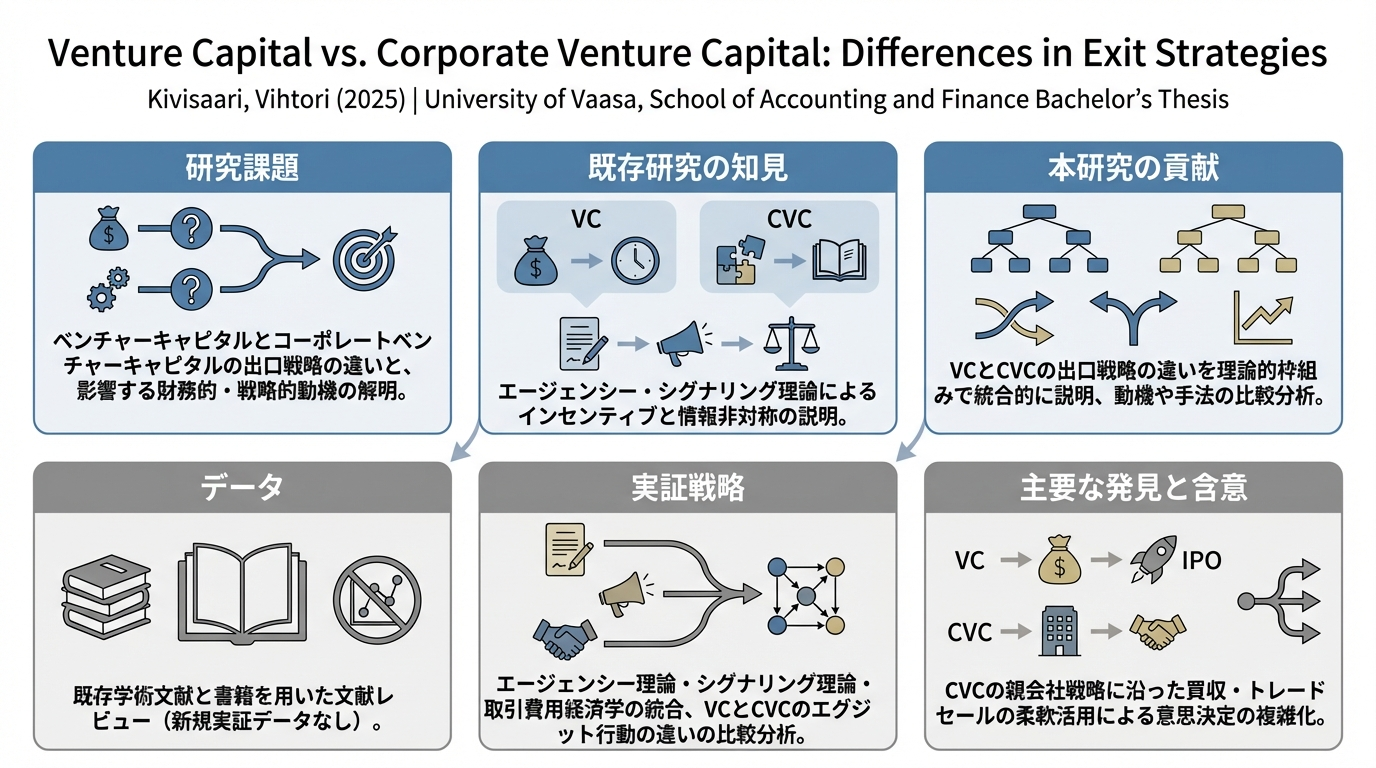

In [49]:
# ============================================================
# 8. Slide Image Generation (Gemini / Nano Banana)
# ============================================================
#
# This section generates a slide-style image from STRUCTURED_SPEC_TEXT
# using Gemini image generation (e.g., gemini-3-pro-image-preview).
#
# Key changes (aligned with Step 7 "body" format):
# - Body text is 1–2 short sentences per box (NO bullet lists)
# - Title/Subtitle remain English; box headers + body follow SLIDE_LANGUAGE
# - Uses CONFIG as single source of truth
# - Uses gemini_client (avoid overwriting OpenAI client)
# - Robust extraction of image bytes across response variants
# - Safe filenames + prompt persistence
#
# Inputs:
#   - CONFIG                (from Step 2)
#   - STRUCTURED_SPEC_TEXT  (from Step 7)
#   - PDF_META, PDF_RUN_DIR (from Step 3)
#   - GEMINI_IMAGE_MODEL, IMAGE_FORMAT, SLIDE_OUT_DIR (from Step 2)
#   - gemini_client         (from Step 1)
#
# Outputs:
#   - SLIDE_IMAGE_PATH (Path)
#

import re
from pathlib import Path
from datetime import datetime

# ----------------------------
# Validate prerequisites
# ----------------------------

if "CONFIG" not in globals():
    raise ValueError("CONFIG is not set. Run Step 2 (Configuration UI) first.")

if "STRUCTURED_SPEC_TEXT" not in globals():
    raise ValueError("STRUCTURED_SPEC_TEXT is not set. Run Step 7 first.")

if "PDF_META" not in globals() or "PDF_RUN_DIR" not in globals():
    raise ValueError("PDF_META / PDF_RUN_DIR not set. Run Step 3 first.")

# Gemini client (Step 1)
if "gemini_client" not in globals():
    raise ValueError("gemini_client is not initialized. Run Step 1 (Environment & API Setup).")

# ----------------------------
# Resolve slide output directory (single source of truth)
# ----------------------------
from pathlib import Path

if "PDF_RUN_DIR" not in globals():
    raise ValueError("PDF_RUN_DIR not set. Run Step 3 first.")

SLIDE_OUT_DIR = Path(PDF_RUN_DIR) / "slides"
SLIDE_OUT_DIR.mkdir(parents=True, exist_ok=True)

print("📂 Slide output dir:", SLIDE_OUT_DIR)

SLIDE_LANGUAGE = CONFIG.slide_language
SLIDE_TYPE = CONFIG.slide_type

print("✅ Starting slide image generation")
print("  - model        :", GEMINI_IMAGE_MODEL)
print("  - slide_lang   :", SLIDE_LANGUAGE)
print("  - slide_type   :", SLIDE_TYPE)

# ----------------------------
# Build final image prompt (strict, BODY-mode)
# ----------------------------
# NOTE: Step 7 spec already includes "NO bullets" and 1–2 short sentences per box.
# We reinforce that here.
if SLIDE_LANGUAGE == "ja":
    language_block = """
LANGUAGE:
- Title / subtitle: English (single line)
- Box titles & content: Japanese only
- Do NOT mix English into boxes
"""
else:
    language_block = """
LANGUAGE:
- Title / subtitle: English (single line)
- Box titles & content: English only
- Do NOT use Japanese characters inside boxes
"""
body_lang_rules = ""
if SLIDE_LANGUAGE == "ja":
    body_lang_rules = """
BODY LANGUAGE RULES:
- All section headers and all body text inside boxes must be Japanese.
- Do NOT include English words/sentences in boxes.
- Roman alphabet (A–Z) inside boxes is not allowed, except for:
  - author names in Title/Subtitle area only
  - numbers (0-9) and common symbols (%, +, -, /)
"""

PROMPT = f"""
You are a professional academic infographic designer.

Create ONE slide based strictly on the spec below.

TEXT RULES:
- All box content must be noun phrases (体言止め)
- No explanatory sentences
- Short, slide-native labels only

VISUAL RULES:
- 2–3 simple icons per box
- If phrases include arrows (→), visualize them clearly
- Use arrows, flow, and grouping to show relationships
- Prioritize structure and readability over text

LAYOUT:
- 2x3 grid (six boxes)
- Generous spacing
- Large typography

 {language_block}

SPEC:
{STRUCTURED_SPEC_TEXT}
""".strip()

# ----------------------------
# Call Gemini image model
# ----------------------------
resp = gemini_client.models.generate_content(
    model=GEMINI_IMAGE_MODEL,
    contents=PROMPT,
)

# ----------------------------
# Extract image bytes (robust)
# ----------------------------
image_bytes = None
mime_type = None

# Case A: resp.candidates[0].content.parts[*].inline_data
try:
    for cand in getattr(resp, "candidates", []) or []:
        content = getattr(cand, "content", None)
        if not content:
            continue
        for p in getattr(content, "parts", []) or []:
            inline = getattr(p, "inline_data", None)
            if inline and getattr(inline, "data", None):
                image_bytes = inline.data
                mime_type = getattr(inline, "mime_type", None)
                break
        if image_bytes is not None:
            break
except Exception:
    pass

# Case B (fallback): resp.parts[*].inline_data
if image_bytes is None:
    try:
        for p in getattr(resp, "parts", []) or []:
            inline = getattr(p, "inline_data", None)
            if inline and getattr(inline, "data", None):
                image_bytes = inline.data
                mime_type = getattr(inline, "mime_type", None)
                break
    except Exception:
        pass

if image_bytes is None:
    print("❌ Could not find inline image data in the Gemini response.")
    print("Raw response (for debugging):")
    print(resp)
    raise RuntimeError("Gemini image generation returned no image bytes.")

# ----------------------------
# Decide extension
# ----------------------------
ext = "png"
if mime_type == "image/jpeg":
    ext = "jpg"
elif isinstance(IMAGE_FORMAT, str) and IMAGE_FORMAT.lower() in ["png", "jpg", "jpeg"]:
    ext = "jpg" if IMAGE_FORMAT.lower() in ["jpg", "jpeg"] else "png"

# ----------------------------
# Safe output filename
# ----------------------------
def safe_slug(s: str, max_len: int = 90) -> str:
    s = (s or "").strip().replace(".pdf", "")
    # keep alnum/_/- only
    s = re.sub(r"[^\w\-]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s[:max_len] if s else "paper"

ts = datetime.now().strftime("%Y%m%d_%H%M%S")
stem = safe_slug(PDF_META.get("filename", "paper"))
out_name = f"{stem}__{SLIDE_TYPE}__{SLIDE_LANGUAGE}__{ts}.{ext}"

SLIDE_IMAGE_PATH = SLIDE_OUT_DIR / out_name
SLIDE_IMAGE_PATH.write_bytes(image_bytes)

print("✅ Slide image saved:", SLIDE_IMAGE_PATH)

# ----------------------------
# Persist prompt used (debug/repro)
# ----------------------------
prompt_path = PDF_RUN_DIR / "slide_image_prompt.txt"
prompt_path.write_text(PROMPT, encoding="utf-8")
print("✅ Saved image prompt to:", prompt_path)

# ----------------------------
# Optional: display inline
# ----------------------------
try:
    from IPython.display import Image, display
    display(Image(filename=str(SLIDE_IMAGE_PATH)))
except Exception as e:
    print("ℹ️ Inline image preview not available:", repr(e))


In [50]:
# ============================================================
# 9. Save Data (Google Drive)
# ============================================================
#
# This section saves the generated artifacts to Google Drive:
#   - Original PDF (if not already stored)
#   - Generated slide image
#
# Files are uploaded with clear, human-readable titles to a
# designated Google Drive folder.
#
# Design principles:
# - Use CONFIG as the single source of truth
# - Deterministic filenames (timestamp + paper title)
# - Idempotent-friendly (safe to re-run with new timestamps)
#
# Inputs:
#   - CONFIG
#   - PDF_META
#   - LOCAL_PDF_PATH (or cached PDF path)
#   - SLIDE_IMAGE_PATH
#   - DRIVE_FOLDER_ID
#   - Google Drive service (authenticated)
#
# Outputs:
#   - DRIVE_PDF_FILE_ID
#   - DRIVE_SLIDE_FILE_ID
#

# ============================================================
# Google Drive Authentication
# ============================================================
#
# This cell authenticates Google Drive access and creates
# a reusable `drive_service` object.
#
# It uses OAuth Desktop App flow and stores credentials locally.
#

# ============================================================
# Google Drive Auth (token.json primary, re-OAuth on invalid_grant)
# ============================================================

from pathlib import Path
from google.oauth2.credentials import Credentials
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow

SCOPES = ["https://www.googleapis.com/auth/drive.file"]

TOKEN_PATH = Path("token.json")           # token.json next to notebook
CLIENT_SECRET_PATH = Path("client_secret_750875982200-85rnsoqhr2af2b13peueev0bm60q22sh.apps.googleusercontent.com.json")  # place once next to notebook

def build_drive_service_from_token(token_path: Path):
    creds = Credentials.from_authorized_user_file(str(token_path), SCOPES)
    if creds.valid:
        return creds

    if creds.expired and creds.refresh_token:
        try:
            creds.refresh(Request())
            token_path.write_text(creds.to_json(), encoding="utf-8")
            print("🔄 token.json refreshed")
            return creds
        except Exception as e:
            # invalid_grant is the most common
            print("⚠️ Refresh failed:", repr(e))
            return None
    return None

def run_oauth_and_save_token(client_secret_path: Path, token_path: Path):
    if not client_secret_path.exists():
        raise FileNotFoundError(
            f"{client_secret_path.resolve()} not found.\n"
            "Place your OAuth Desktop client secret as client_secret.json next to the notebook."
        )
    flow = InstalledAppFlow.from_client_secrets_file(str(client_secret_path), SCOPES)
    creds = flow.run_local_server(port=0)
    token_path.write_text(creds.to_json(), encoding="utf-8")
    print(f"💾 token.json regenerated: {token_path.resolve()}")
    return creds

# 1) Try token.json
creds = None
if TOKEN_PATH.exists():
    creds = build_drive_service_from_token(TOKEN_PATH)

# 2) If token is missing or refresh failed -> re-OAuth
if creds is None:
    print("🔐 Re-authentication required (token expired/revoked).")
    creds = run_oauth_and_save_token(CLIENT_SECRET_PATH, TOKEN_PATH)

# 3) Build Drive service
drive_service = build("drive", "v3", credentials=creds)

print("✅ Google Drive service initialized")





from pathlib import Path
from datetime import datetime
from googleapiclient.http import MediaFileUpload

# ----------------------------
# Validate prerequisites
# ----------------------------
if "DRIVE_FOLDER_ID" not in globals() or not DRIVE_FOLDER_ID:
    raise ValueError("DRIVE_FOLDER_ID is not set. Check env.txt and Step 1.")

if "drive_service" not in globals():
    raise ValueError("Google Drive service is not initialized. Run Drive auth cell first.")

if "PDF_META" not in globals():
    raise ValueError("PDF_META not found. Run Step 3 (PDF Ingestion).")

if "SLIDE_IMAGE_PATH" not in globals():
    raise ValueError("SLIDE_IMAGE_PATH not found. Run Step 8 first.")

print("✅ Starting save-to-Drive step")

# ----------------------------
# Helper: build human-readable titles
# ----------------------------
def build_drive_title(base_title: str, suffix: str, ext: str) -> str:
    """
    Example:
      Liberalizing Home-Based Business__slides__20260102.png
    """
    ts = datetime.now().strftime("%Y%m%d")
    safe = base_title.replace("/", "_").replace(":", "").strip()
    return f"{safe}__{suffix}__{ts}.{ext}"

BASE_TITLE = PDF_META.get("title") or PDF_META.get("filename", "paper").replace(".pdf", "")

# ----------------------------
# Upload PDF (optional)
# ----------------------------
DRIVE_PDF_FILE_ID = None

pdf_path = Path(PDF_META.get("path", ""))
if pdf_path.exists():
    pdf_title = build_drive_title(BASE_TITLE, "paper", "pdf")

    media = MediaFileUpload(
        pdf_path,
        mimetype="application/pdf",
        resumable=True,
    )

    pdf_file = drive_service.files().create(
        body={
            "name": pdf_title,
            "parents": [DRIVE_FOLDER_ID],
        },
        media_body=media,
        fields="id, name",
    ).execute()

    DRIVE_PDF_FILE_ID = pdf_file["id"]
    print(f"✅ PDF uploaded to Drive: {pdf_file['name']}")
else:
    print("⚠️ PDF path not found; skipping PDF upload")

# ----------------------------
# Upload slide image
# ----------------------------
slide_path = Path(SLIDE_IMAGE_PATH)
slide_ext = slide_path.suffix.lstrip(".")
slide_title = build_drive_title(BASE_TITLE, "slide", slide_ext)

media = MediaFileUpload(
    slide_path,
    mimetype=f"image/{slide_ext}",
    resumable=True,
)

slide_file = drive_service.files().create(
    body={
        "name": slide_title,
        "parents": [DRIVE_FOLDER_ID],
    },
    media_body=media,
    fields="id, name",
).execute()

DRIVE_SLIDE_FILE_ID = slide_file["id"]

print(f"✅ Slide image uploaded to Drive: {slide_file['name']}")

# ----------------------------
# Summary
# ----------------------------
print("\n--- Drive Upload Summary ---")
print("PDF file ID  :", DRIVE_PDF_FILE_ID)
print("Slide file ID:", DRIVE_SLIDE_FILE_ID)


✅ Google Drive service initialized
✅ Starting save-to-Drive step
✅ PDF uploaded to Drive: Vhtori Kivisaari Kandi__paper__20260115.pdf
✅ Slide image uploaded to Drive: Vhtori Kivisaari Kandi__slide__20260115.jpg

--- Drive Upload Summary ---
PDF file ID  : 1EF-pjfen3_UhE8GbNHcY2qvI23muaspG
Slide file ID: 1-lMF4jAs2kJZUOwKmoQlYBw13hVFSPKW


In [51]:
# ============================================================
# 10. Update Notion: Set PDF Link
# ============================================================
#
# This section:
# - Generates a shareable Google Drive link for the uploaded PDF
# - Writes the link to the "PDF Link" property in the Notion page
#
# Inputs:
#   - drive_service
#   - DRIVE_PDF_FILE_ID
#   - NOTION_PAGE_ID
#   - NOTION_HEADERS
#
# Output:
#   - Updated Notion page
#

import requests

# ----------------------------
# Validate prerequisites
# ----------------------------
if "DRIVE_PDF_FILE_ID" not in globals() or not DRIVE_PDF_FILE_ID:
    raise ValueError("DRIVE_PDF_FILE_ID not found. Run Step 9 first.")

if "NOTION_PAGE_ID" not in globals() or not NOTION_PAGE_ID:
    raise ValueError("NOTION_PAGE_ID not found. Run Step 6 (Notion page creation).")

print("✅ Starting Notion PDF Link update")

# ----------------------------
# 1. Ensure Drive file is shareable (view-only)
# ----------------------------
drive_service.permissions().create(
    fileId=DRIVE_PDF_FILE_ID,
    body={
        "role": "reader",
        "type": "anyone",
    },
).execute()

# ----------------------------
# 2. Build Drive share URL
# ----------------------------
PDF_DRIVE_URL = f"https://drive.google.com/file/d/{DRIVE_PDF_FILE_ID}/view"

print("🔗 Drive PDF URL:")
print(PDF_DRIVE_URL)

# ----------------------------
# 3. Update Notion page property
# ----------------------------
payload = {
    "properties": {
        "PDF Link": {
            "url": PDF_DRIVE_URL
        }
    }
}

r = requests.patch(
    f"https://api.notion.com/v1/pages/{NOTION_PAGE_ID}",
    headers=NOTION_HEADERS,
    json=payload,
    timeout=30,
)

if r.status_code != 200:
    print("❌ Failed to update Notion page")
    print(r.json())
    raise RuntimeError("Notion PDF Link update failed")

print("✅ Notion page updated with PDF Link")


✅ Starting Notion PDF Link update
🔗 Drive PDF URL:
https://drive.google.com/file/d/1EF-pjfen3_UhE8GbNHcY2qvI23muaspG/view
✅ Notion page updated with PDF Link
